In [15]:
# Jannik's models are not SAE Lens, so use Baukit
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "EleutherAI/pythia-70m"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

import os 
import sys
current_dir = "/root/GroupedSAEs/notebooks/circuits.ipynb"
sys.path.append(os.path.dirname(os.path.dirname(current_dir)))
from huggingface_hub import hf_hub_download
from dictionary import GatedAutoEncoder

# Possible layers: 2,8,12,14,16,20
layer = 2
activation_names = [f"gpt_neox.layers.{layer}", f"gpt_neox.layers.{layer}.post_attention_layernorm"]
# activation_name = f"transformer.h.{layer}"

model_id = "jbrinkma/pythia-70m-saes"
normal_sae_name = f"Pythia-70M-L{layer}-Residual.pt"
skip_sae_name = f"Pythia-70M-L{layer}-SkipMLP.pt"
normal_ae_download_location = hf_hub_download(repo_id=model_id, filename=normal_sae_name)
skip_ae_download_location = hf_hub_download(repo_id=model_id, filename=skip_sae_name)
sae_res = GatedAutoEncoder.from_pretrained(normal_ae_download_location).to(device)
skip_sae = GatedAutoEncoder.from_pretrained(skip_ae_download_location).to(device)

from datasets import load_dataset
def download_dataset(dataset_name, tokenizer, max_length=256, num_datapoints=None):
    if(num_datapoints):
        split_text = f"train[:{num_datapoints}]"
    else:
        split_text = "train"
    dataset = load_dataset(dataset_name, split=split_text).map(
        lambda x: tokenizer(x['text']),
        batched=True,
    ).filter(
        lambda x: len(x['input_ids']) > max_length
    ).map(
        lambda x: {'input_ids': x['input_ids'][:max_length]}
    )
    return dataset

dataset_name = "Elriggs/openwebtext-100k"
# dataset_name = "stas/openwebtext-10k"
max_seq_length = 256
num_datapoints = 50000
total_tokens = max_seq_length * num_datapoints
print(f"Total num of Tokens: {total_tokens/1e6}M")
print(f"Downloading {dataset_name}")
dataset = download_dataset(dataset_name, tokenizer=tokenizer, max_length=max_seq_length, num_datapoints=num_datapoints)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total num of Tokens: 12.8M


Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/45822 [00:00<?, ? examples/s]

In [20]:
from torch import nn
class two_linear(nn.Module):
    def __init__(self, input_size, output_size, output_bias=False, relu=False):
        super().__init__()
        self.linear_first = nn.Linear(input_size, output_size, bias=False)
        self.linear_second = nn.Linear(output_size, input_size, bias=output_bias)
        # initialize the weights of the linear layers
        nn.init.xavier_uniform_(self.linear_first.weight)
        nn.init.xavier_uniform_(self.linear_second.weight)
        self.relu = relu
    def forward(self, x):
        res_x = self.linear_first(x)
        output= self.linear_second(res_x)
        if self.relu:
            return torch.relu(output) 
        return output
    
    def get_weights(self):
        return self.linear_first.weight @ self.linear_second.weight

    def get_bias(self):
        return self.linear_second.bias
    
output_bias = False
res_size, feature_size = skip_sae.decoder.weight.shape
linear_layers = two_linear(feature_size, res_size, output_bias=output_bias, relu=False)
opt = torch.optim.Adam(linear_layers.parameters(), lr=1e-3)

initialize_to_SAE = False
res_dec = skip_sae.decoder.weight.data
# Initialize the weights of the linear layers to SAE_encoder & decoder weights
# I'd like to fold in layer norm
if initialize_to_SAE:
    # I'd like to fold in layer norm
    ln_mlp = model.gpt_neox.layers[layer].post_attention_layernorm
    # 1. center the weights that write into res
    # centered_decoder = res_dec - res_dec.mean(dim=1, keepdim=True)
    centered_decoder = res_dec
    # 2. Add in layer norm weight to the read in weight
    ln_w = ln_mlp.weight.data
    ln_b = ln_mlp.bias.data

    # Get weights and biases of the next linear layer
    W = skip_sae.encoder.weight.data.T  # The next linear layer weights
    # B = skip_sae.mag_bias.data  # The next linear layer biases
    B = skip_sae.gate_bias.data  # The next linear layer biases

    # Calculate W_eff and B_eff
    W_eff = torch.diag(ln_w) @ W
    B_eff = B + ln_b @ W

    # Centering the reading weights
    # W_eff -= W_eff.mean(dim=0, keepdim=True)

    # assign to two linear
    linear_layers.linear_first.weight.data = centered_decoder
    linear_layers.linear_second.weight.data = W_eff.T
    if output_bias:
        linear_layers.linear_second.bias.data = B_eff
# set to gpu
linear_layers.to(device)

two_linear(
  (linear_first): Linear(in_features=8192, out_features=512, bias=False)
  (linear_second): Linear(in_features=512, out_features=8192, bias=False)
)

In [21]:
linear_layers.linear_second.weight.shape
linear_layers.linear_first.weight.shape

torch.Size([512, 8192])

In [22]:
# set them to false
for param in model.parameters():
    param.requires_grad = False
# Same for saes
for param in sae_res.parameters():
    param.requires_grad = False
for param in skip_sae.parameters():
    param.requires_grad = False

In [23]:
from torch.utils.data import DataLoader
from einops import rearrange
from tqdm import tqdm
from baukit import TraceDict
# set gradient off for model & saes
batch_size = 128
num_batches_check = 20
# def get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32):
num_features, d_model  = sae_res.encoder.weight.data.shape
datapoints = dataset.num_rows

residual_and_skip_correlation = torch.zeros((num_features, num_features), dtype=torch.int32)
residual_correlation = torch.zeros((num_features, num_features), dtype=torch.int32)
skip_correlation = torch.zeros((num_features, num_features), dtype=torch.int32)

all_resid_mse = []
all_resid_var_explained = []
all_feature_mse = []
all_feature_var_explained = []
with dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for batch_ind, batch in enumerate(tqdm(dl)):
        batch = batch.to(model.device)
        # Grab intermediate activations
        with TraceDict(model, activation_names) as ret:
            _ = model(batch).logits
        # Get each feature's activations

        for sae_ind, sae in enumerate([sae_res, skip_sae]):
            activations = ret[activation_names[sae_ind]].output
            # check if instance tuple
            if(isinstance(activations, tuple)):
                activations = activations[0]
                
            activations = rearrange(activations, "b s n -> (b s) n" )

            feature_acts = sae.encode(activations)
            if sae_ind==0:
                input_features = feature_acts

                # Calculate the MSE loss between the original activation & it's encoded version
                resid_mse = torch.mean((activations - linear_layers.linear_first(feature_acts))**2)
                first_feature_mask = (feature_acts !=0).float()
                residual_correlation += torch.mm(first_feature_mask.T, first_feature_mask).int().cpu()
            else:
                skip_features = feature_acts
                second_feature_mask = (feature_acts !=0).float()
                skip_correlation += torch.mm(second_feature_mask.T, second_feature_mask).int().cpu()
                
                # Calculate the correlation between the residual and skip activations
                residual_and_skip_correlation += torch.mm(first_feature_mask.T, second_feature_mask).int().cpu()

                # Calculate feature approximation
                skip_features_hat = linear_layers(input_features)
                
                # Check the MSE between the skip features & skip-features-w/-residual
                skip_feature_mse = torch.mean((skip_features - skip_features_hat)**2)

                loss = skip_feature_mse + resid_mse
                opt.zero_grad()
                loss.backward()
                opt.step()
                
                if batch_ind % num_batches_check == 0:
                    print(f"Batch {batch_ind} | resid_mse: {resid_mse:.3f} skip_mse: {skip_feature_mse:.3f}")
                    all_resid_mse.append(resid_mse.item())
                    all_feature_mse.append(skip_feature_mse.item())
                    feature_act_var = torch.var(skip_features)
                    skip_feature_var_explained = 1 - skip_feature_mse / feature_act_var
                    all_feature_var_explained.append(skip_feature_var_explained)
                # feature_act_var = torch.var(skip_features)
                # skip_feature_var_explained = 1 - skip_feature_mse / feature_act_var

                # feature_mse[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = skip_feature_mse.cpu()
                # feature_var_explained[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = skip_feature_var_explained.cpu()

  0%|          | 1/358 [00:01<10:21,  1.74s/it]

Batch 0 | resid_mse: 0.639 skip_mse: 0.017


  6%|▌         | 21/358 [00:29<07:40,  1.37s/it]

Batch 20 | resid_mse: 0.453 skip_mse: 0.012


 11%|█▏        | 41/358 [00:57<07:24,  1.40s/it]

Batch 40 | resid_mse: 0.381 skip_mse: 0.009


 17%|█▋        | 61/358 [01:30<08:07,  1.64s/it]

Batch 60 | resid_mse: 0.332 skip_mse: 0.007


 23%|██▎       | 81/358 [02:00<06:28,  1.40s/it]

Batch 80 | resid_mse: 0.296 skip_mse: 0.005


 28%|██▊       | 101/358 [02:27<05:49,  1.36s/it]

Batch 100 | resid_mse: 0.265 skip_mse: 0.004


 34%|███▍      | 121/358 [02:55<05:22,  1.36s/it]

Batch 120 | resid_mse: 0.238 skip_mse: 0.003


 39%|███▉      | 141/358 [03:23<04:56,  1.37s/it]

Batch 140 | resid_mse: 0.221 skip_mse: 0.002


 45%|████▍     | 161/358 [03:56<06:01,  1.84s/it]

Batch 160 | resid_mse: 0.203 skip_mse: 0.002


 51%|█████     | 181/358 [04:23<04:05,  1.39s/it]

Batch 180 | resid_mse: 0.182 skip_mse: 0.001


 56%|█████▌    | 201/358 [04:52<04:27,  1.70s/it]

Batch 200 | resid_mse: 0.170 skip_mse: 0.001


 62%|██████▏   | 221/358 [05:21<03:18,  1.45s/it]

Batch 220 | resid_mse: 0.159 skip_mse: 0.001


 67%|██████▋   | 241/358 [05:54<02:48,  1.44s/it]

Batch 240 | resid_mse: 0.146 skip_mse: 0.001


 73%|███████▎  | 261/358 [06:24<02:21,  1.46s/it]

Batch 260 | resid_mse: 0.135 skip_mse: 0.001


 78%|███████▊  | 281/358 [06:50<01:42,  1.34s/it]

Batch 280 | resid_mse: 0.125 skip_mse: 0.001


 84%|████████▍ | 301/358 [07:19<01:20,  1.42s/it]

Batch 300 | resid_mse: 0.113 skip_mse: 0.001


 90%|████████▉ | 321/358 [07:48<00:51,  1.40s/it]

Batch 320 | resid_mse: 0.109 skip_mse: 0.001


 95%|█████████▌| 341/358 [08:15<00:23,  1.35s/it]

Batch 340 | resid_mse: 0.099 skip_mse: 0.001


100%|██████████| 358/358 [08:38<00:00,  1.45s/it]


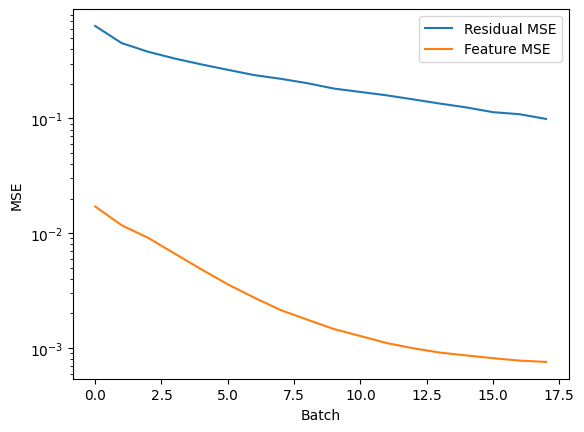

In [25]:
# plot all_resid_mse & all_feature_mse
import matplotlib.pyplot as plt
plt.plot(all_resid_mse, label="Residual MSE")
plt.plot(all_feature_mse, label="Feature MSE")
plt.legend()
plt.xlabel("Batch")
plt.ylabel("MSE")
plt.yscale("log")
plt.show()

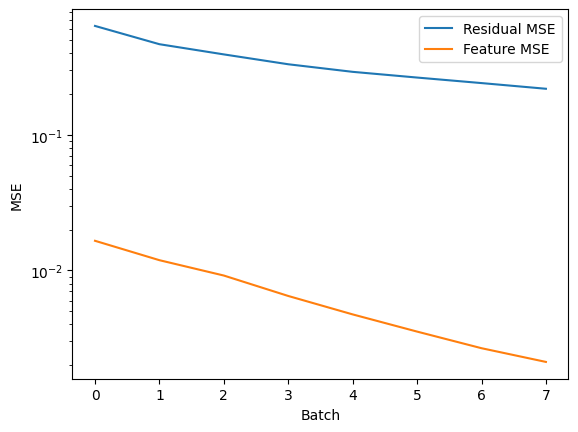

In [31]:
# plot all_resid_mse & all_feature_mse
import matplotlib.pyplot as plt
plt.plot(all_resid_mse.numpy(), label="Residual MSE")
plt.plot(all_feature_mse.numpy(), label="Feature MSE")
plt.legend()
plt.xlabel("Batch")
plt.ylabel("MSE")
plt.yscale("log")
plt.show()

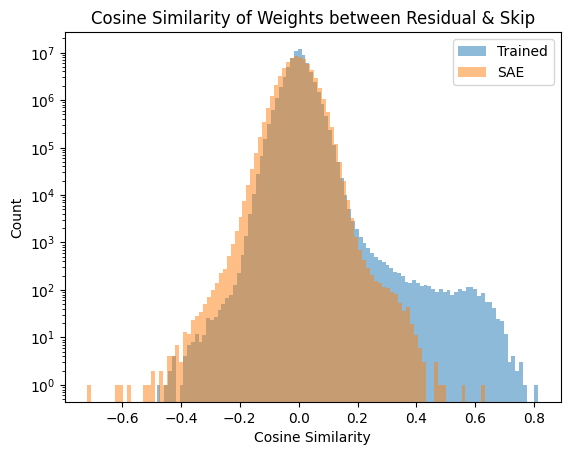

In [68]:
# Get combined weights
comb_weight = linear_layers.get_weights()
l1 = linear_layers.linear_first.weight
l2 = linear_layers.linear_second.weight
cos_sim = (l1 / l1.norm(dim=0, keepdim=True)).T @ (l2 / l2.norm(dim=1, keepdim=True)).T
plt.hist(cos_sim.detach().flatten().cpu().numpy(), bins=100, label="Trained", alpha=0.5)
l1 = sae_res.decoder.weight.data
l2 = skip_sae.encoder.weight.data
cos_sim = (l1 / l1.norm(dim=0, keepdim=True)).T @ (l2 / l2.norm(dim=1, keepdim=True)).T
plt.hist(cos_sim.detach().flatten().cpu().numpy(), bins=100, label="SAE", alpha=0.5)
plt.legend()
plt.title("Cosine Similarity of Weights between Residual & Skip")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.yscale("log")
plt.show()

In [70]:
import networkx as nx
import torch
from bokeh.io import show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, Circle, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx

output_notebook()

# Define your matrices (example data)
num_features = 5  # Example number of features
within_res_correlation = torch.randn(num_features, num_features)
res_skip_correlation = torch.randn(num_features, num_features)
within_skip_correlation = torch.randn(num_features, num_features)

# Create graph
G = nx.Graph()

# Add nodes with hover info
for i in range(num_features):
    G.add_node(f'res_{i}', group='res', color='blue', name=f'Res_{i}')
    G.add_node(f'skip_{i}', group='skip', color='red', name=f'Skip_{i}')

# Add edges within res group
for i in range(num_features):
    for j in range(num_features):
        if i != j:
            G.add_edge(f'res_{i}', f'res_{j}', weight=within_res_correlation[i, j].item(), color='blue')

# Add edges within skip group
for i in range(num_features):
    for j in range(num_features):
        if i != j:
            G.add_edge(f'skip_{i}', f'skip_{j}', weight=within_skip_correlation[i, j].item(), color='red')

# Add edges between res and skip groups
for i in range(num_features):
    for j in range(num_features):
        G.add_edge(f'res_{i}', f'skip_{j}', weight=res_skip_correlation[i, j].item(), color='green')

# Create plot
plot = figure(title="Feature Correlation Graph", x_range=(-1.5, 1.5), y_range=(-1.5, 1.5),
              tools="", toolbar_location=None)

# Add hover tool
hover = HoverTool(tooltips=[("Name", "@name"), ("Group", "@group"), ("Weight", "@weight")])
plot.add_tools(hover)

# Create network graph layout
pos = nx.spring_layout(G)
nx.set_node_attributes(G, pos, 'pos')
network_graph = from_networkx(G, pos, scale=2, center=(0, 0))

# Customize node appearance
network_graph.node_renderer.glyph = Circle(radius=0.05, fill_color='color')
network_graph.node_renderer.hover_glyph = Circle(radius=0.05, fill_color='color', line_width=2)
network_graph.node_renderer.selection_glyph = Circle(radius=0.05, fill_color='color', line_width=2)

# Customize edge appearance
network_graph.edge_renderer.glyph = MultiLine(line_color='color', line_alpha=0.8, line_width='weight')
network_graph.edge_renderer.hover_glyph = MultiLine(line_color='color', line_width=5)
network_graph.edge_renderer.selection_glyph = MultiLine(line_color='color', line_width=5)

# Add network graph to plot
plot.renderers.append(network_graph)

# Show plot
show(plot)


Loading BokehJS ...

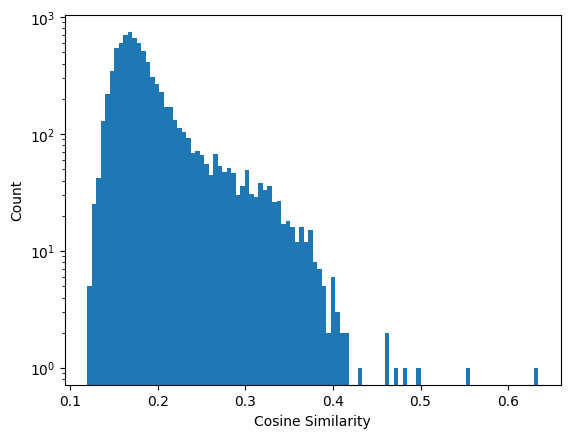

In [60]:
# Get combined weights
comb_weight = linear_layers.get_weights()
l1 = sae_res.decoder.weight.data
l2 = skip_sae.encoder.weight.data
cos_sim = (l1 / l1.norm(dim=0, keepdim=True)).T @ (l2 / l2.norm(dim=1, keepdim=True)).T
plt.hist(cos_sim.detach().max(0).values.flatten().cpu().numpy(), bins=100)
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.yscale("log")
plt.show()

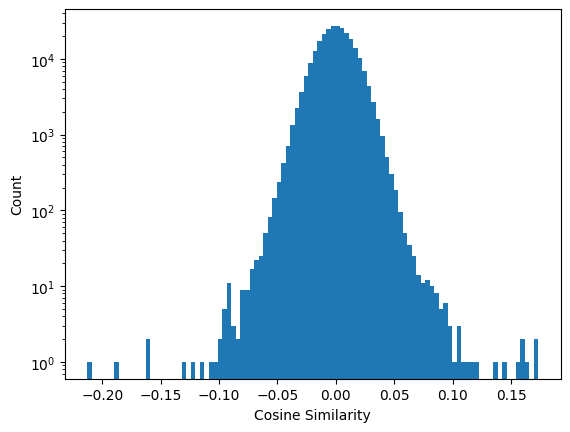

In [40]:
# Get combined weights
comb_weight = linear_layers.get_weights()
# l1 = linear_layers.linear_first.weight
# l2 = linear_layers.linear_second.weight
# cos_sim = (l1 / l1.norm(dim=0, keepdim=True)).T @ (l2 / l2.norm(dim=1, keepdim=True)).T
plt.hist(comb_weight.detach().flatten().cpu().numpy(), bins=100)
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.yscale("log")
plt.show()

In [52]:
l1.norm(dim=0).mean(), l2.norm(dim=1).mean(), sae_res.decoder.weight.data.norm(dim=0).mean(),  sae_res.encoder.weight.data.norm(dim=1).mean(), skip_sae.encoder.weight.data.norm(dim=1).mean(), skip_sae.decoder.weight.data.norm(dim=0).mean()

(tensor(0.7484, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0586, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1., device='cuda:0'),
 tensor(1.3561, device='cuda:0'),
 tensor(0.7563, device='cuda:0'),
 tensor(1., device='cuda:0'))

In [ ]:
#set torch grad to zero globally
torch.set_grad_enabled(False)
from torch.utils.data import DataLoader
from einops import rearrange
from tqdm import tqdm
from baukit import TraceDict

batch_size = 64
# def get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32):
num_features, d_model  = sae_res.encoder.weight.data.shape
datapoints = dataset.num_rows
dictionary_activations_res = torch.zeros((datapoints*max_seq_length, num_features))
dictionary_activations_skip = torch.zeros((datapoints*max_seq_length, num_features))
all_dictionary_activations = [dictionary_activations_res, dictionary_activations_skip]
token_list = torch.zeros((datapoints*max_seq_length), dtype=torch.int64)


residual_and_skip_correlation = torch.zeros((num_features, num_features), dtype=torch.int32)
residual_correlation = torch.zeros((num_features, num_features), dtype=torch.int32)
skip_correlation = torch.zeros((num_features, num_features), dtype=torch.int32)

feature_mse = torch.zeros(datapoints*max_seq_length)
feature_var_explained = torch.zeros(datapoints*max_seq_length)
with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for batch_ind, batch in enumerate(tqdm(dl)):
        batch = batch.to(model.device)
        token_list[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = rearrange(batch, "b s -> (b s)")

        # Grab intermediate activations
        with TraceDict(model, activation_names) as ret:
            _ = model(batch).logits
        for sae_ind, sae in enumerate([sae_res, skip_sae]):
            activations = ret[activation_names[sae_ind]].output
            # check if instance tuple
            if(isinstance(activations, tuple)):
                activations = activations[0]
                
            activations = rearrange(activations, "b s n -> (b s) n" )

            feature_acts = sae.encode(activations)
            all_dictionary_activations[sae_ind][batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = feature_acts.cpu()
            if sae_ind==0:
                reconstruction_residual = sae.decode(feature_acts)
                first_feature_mask = (feature_acts !=0).float()
                residual_correlation += torch.mm(first_feature_mask.T, first_feature_mask).int().cpu()
            else:
                second_feature_mask = (feature_acts !=0).float()
                skip_correlation += torch.mm(second_feature_mask.T, second_feature_mask).int().cpu()

                # Calculate the correlation between the residual and skip activations
                residual_and_skip_correlation += torch.mm(first_feature_mask.T, second_feature_mask).int().cpu()


                # Check the MSE between the skip features & skip-features-w/-residual
                skip_feature_x_hat = skip_sae.encode(reconstruction_residual)
                skip_feature_mse = torch.mean((skip_feature_x_hat - feature_acts)**2, dim=-1)
                feature_act_var = torch.var(feature_acts)
                skip_feature_var_explained = 1 - skip_feature_mse / feature_act_var
                feature_mse[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = skip_feature_mse.cpu()
                feature_var_explained[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = skip_feature_var_explained.cpu()